<a href="https://colab.research.google.com/github/Laeti-dev/P7-Sentiments_analysis/blob/master/notebooks/P7_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from wordcloud import WordCloud

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


In [2]:
# Set pandas options to display more content in large columns
pd.set_option('display.max_colwidth', None)  # Display full content of columns
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', 100)      # Display up to 100 rows

# Introduction

This notebook aims to get the data from an open source and proceed to an exploratory analysis of the data. In the exploration we will :
- understand the different features
- understand the target distribution (sentiment classes)
- evaluate the relation between time and target
- evaluate the reltion between author and target
- evaluate the relation between flags and target
- get the most frequent words for each targeted tweets
- understand tweets pattern for each target

# Load data

Load the tweets data from the CSV file into a pandas DataFrame.


**About this file**:
This is the sentiment140 dataset.
It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment .
It contains the following 6 fields:

- *target*: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- *ids*: The id of the tweet ( 2087)
- *date*: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- *flag*: The query (lyx). If there is no query, then this value is NO_QUERY.
- *user*: the user that tweeted (robotickilldozr)
- *text*: the text of the tweet (Lyx is cool)



In [3]:
gdrive_path = '/content/drive/MyDrive/OC/Projets/P7/data/training.1600000.processed.noemoticon.csv'
path = "../data/training.1600000.processed.noemoticon.csv"
# Load the data from the CSV file into a pandas DataFrame
data = pd.read_csv(path,
                header=None,
                names=["target", "ids", "date", "flag", "user", "text"],
                usecols=["target", "ids", "date", "user", "text"],  # remove flag column
                parse_dates=["date"],
                encoding="utf-8",
                encoding_errors="replace",)

# Display the first few rows of the DataFrame and its info
display(data.head())
display(data.info())

,target,ids,date,user,text
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  int64         
 2   date    1600000 non-null  datetime64[ns]
 3   user    1600000 non-null  object        
 4   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 61.0+ MB


None

The data set has a the shape (1600000,5) without any obvious missing values

# Genaralities

First, it is important to understand our data and more specifically our target.

What are the possible values?

is it equally distributed or do we need to proceed on some balancing method ?

It is also important to check that all our target are associated with clean, unique features.

## Missing values and duplicates

In [4]:
# Display columns and their data types
print(f'columns: {data.columns}')
print(data.dtypes)

# Check for missing values
print(f'missing values: {data.isnull().sum()}')

# check for duplicates
print(f'duplicates: {data.duplicated().sum()}')

columns: Index(['target', 'ids', 'date', 'user', 'text'], dtype='object')
target             int64
ids                int64
date      datetime64[ns]
user              object
text              object
dtype: object
missing values: target    0
ids       0
date      0
user      0
text      0
dtype: int64
duplicates: 0


In [5]:
# Check if all tweet IDs are unique
if data['ids'].nunique() == len(data):
    print("All tweet IDs are unique. This means each ID is associated with only one user and one tweet.")
else:
    print("There are duplicate tweet IDs in the dataset.")

    # Find which IDs are duplicated
    duplicate_ids_df = data[data.duplicated(subset=['ids'], keep=False)]

    # Check if any of these duplicate IDs are associated with more than one user
    user_per_id = duplicate_ids_df.groupby('ids')['user'].nunique()
    ids_with_multiple_users = user_per_id[user_per_id > 1]

    if ids_with_multiple_users.empty:
        print("However, each tweet ID is still affiliated with only one user.")
        print("\nDisplaying some of the rows with duplicate IDs for inspection:")
        display(duplicate_ids_df.sort_values('ids').head())
    else:
        print("\nWarning: The following tweet IDs are affiliated with more than one user:")
        display(ids_with_multiple_users)

There are duplicate tweet IDs in the dataset.
However, each tweet ID is still affiliated with only one user.

Displaying some of the rows with duplicate IDs for inspection:


,target,ids,date,user,text
213,0,1467863684,2009-04-06 22:33:35,DjGundam,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie
800261,4,1467863684,2009-04-06 22:33:35,DjGundam,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie
275,0,1467880442,2009-04-06 22:38:04,iCalvin,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!"
800300,4,1467880442,2009-04-06 22:38:04,iCalvin,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!"
989,0,1468053611,2009-04-06 23:28:09,mariejamora,@hellobebe I also send some updates in plurk but i upload photos on twitter! you didnt see any of my updates on plurk? Zero?


## Target

In [6]:
# possible values
print(f'possible values: {data["target"].unique()}')

original_df = data.copy()

# Get the duplicates tweets (same user, same date, same text), keep the first and replace the target with 2
duplicates = data.duplicated(subset=['user', 'date', 'text'], keep='first')
print(f'Number of duplicate tweets: {duplicates.sum()}')
data.loc[duplicates, 'target'] = 2

# Convert the target variable to a 0-1 scale (0: Negative, 1: Positive)
data['target'] = data['target'].replace({0: 0, 4: 1})
print(f'Scaled possible values: {data["target"].unique()}')

possible values: [0 4]
Number of duplicate tweets: 1873
Scaled possible values: [0 2 1]


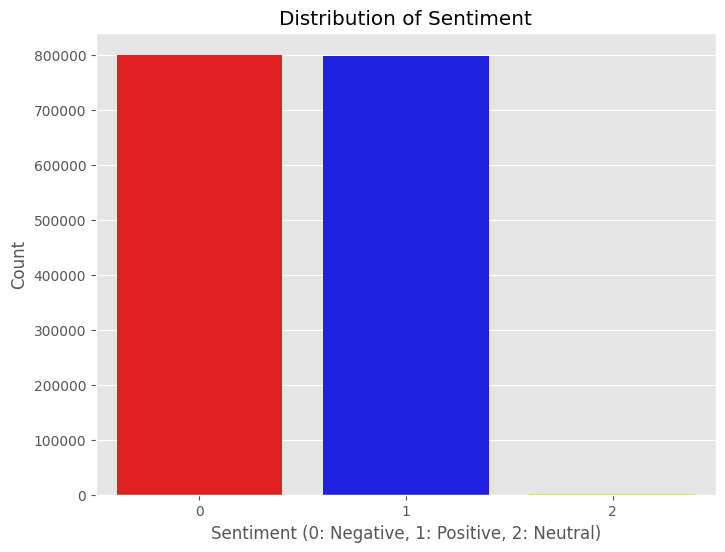

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=data, palette={'0': 'red', '1': 'blue', '2': 'yellow'})
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive, 2: Neutral)')
plt.ylabel('Count')
plt.show()

In [8]:
# Only keep the tweets with target 0 or 1
data = data[data['target'].isin([0, 1])].reset_index(drop=True)

## Target over time

In [9]:
# split the date column into year, month and day columns
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.dayofweek

print(f'Tweets are going from {data["date"].min()} to {data["date"].max()}')
display(data.head())

Tweets are going from 2009-04-06 22:19:45 to 2009-06-25 10:28:31


,target,ids,date,user,text,year,month,day,hour,weekday
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009,4,6,22,0
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009,4,6,22,0
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009,4,6,22,0
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,2009,4,6,22,0
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009,4,6,22,0


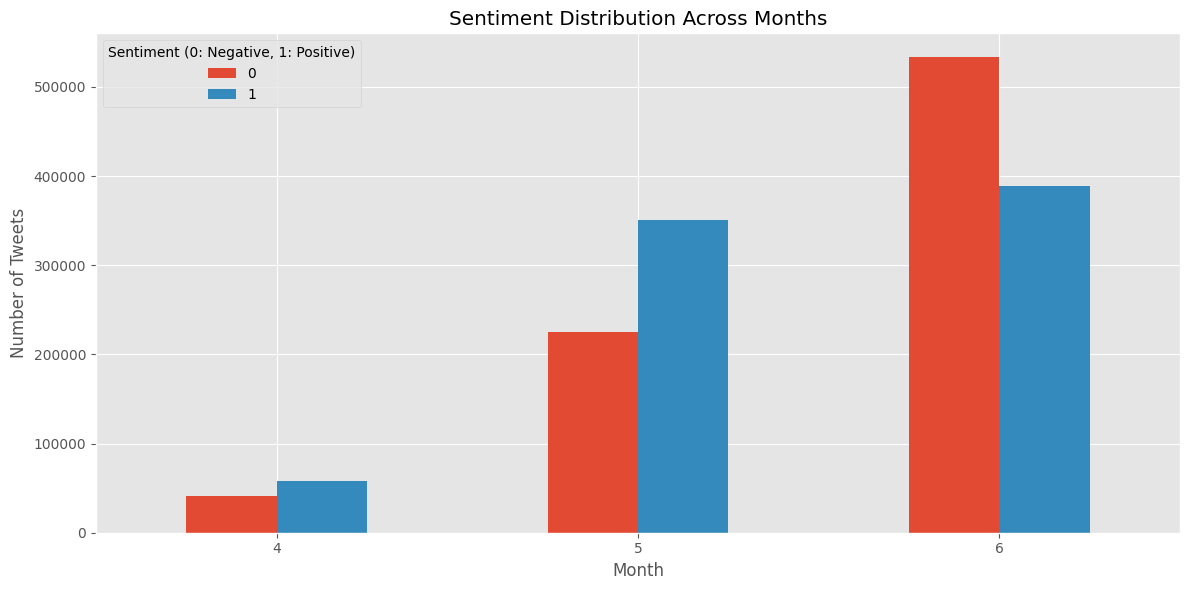

In [10]:
# Group by month and target, then count the occurrences
target_by_month = data.groupby(['month', 'target']).size().unstack(fill_value=0)

# Plot the distribution of sentiments over the months
plt.figure(figsize=(12, 6))
target_by_month.plot(kind='bar', stacked=False, ax=plt.gca())
plt.title('Sentiment Distribution Across Months')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.legend(title='Sentiment (0: Negative, 1: Positive)')
plt.tight_layout()
plt.show()

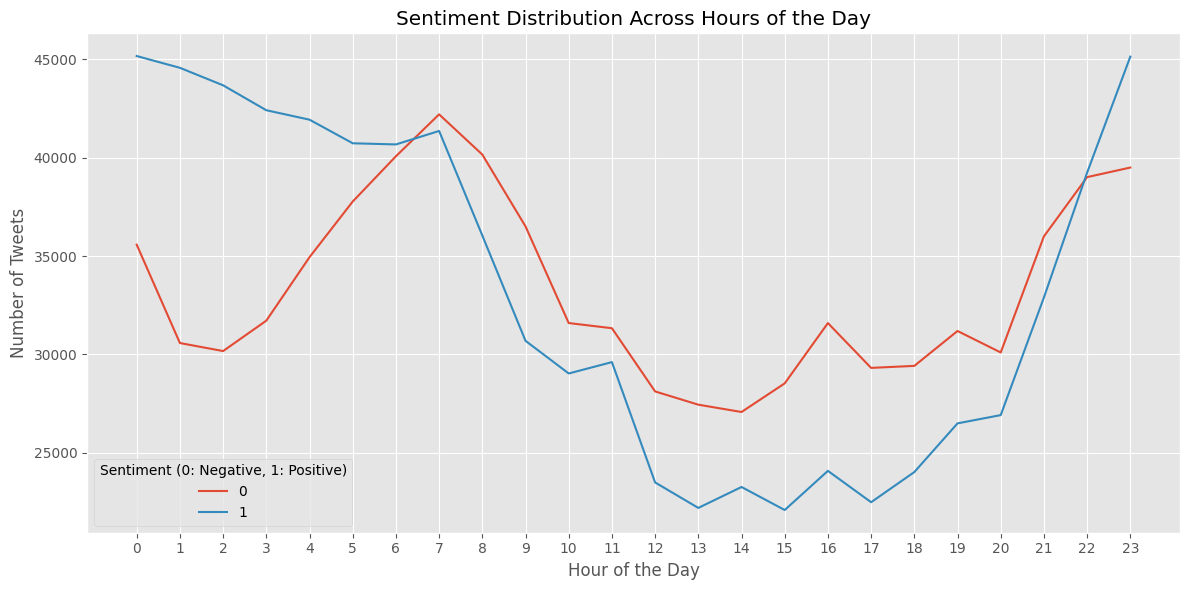

In [11]:
# Group by hour and target, then count the occurrences
target_by_hour = data.groupby(['hour', 'target']).size().unstack(fill_value=0)

# Plot the distribution of sentiments across hours of the day
plt.figure(figsize=(12, 6))
target_by_hour.plot(kind='line', stacked=False, ax=plt.gca())
plt.title('Sentiment Distribution Across Hours of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Tweets')
plt.xticks(range(24))
plt.legend(title='Sentiment (0: Negative, 1: Positive)')
plt.grid(True)
plt.tight_layout()
plt.show()


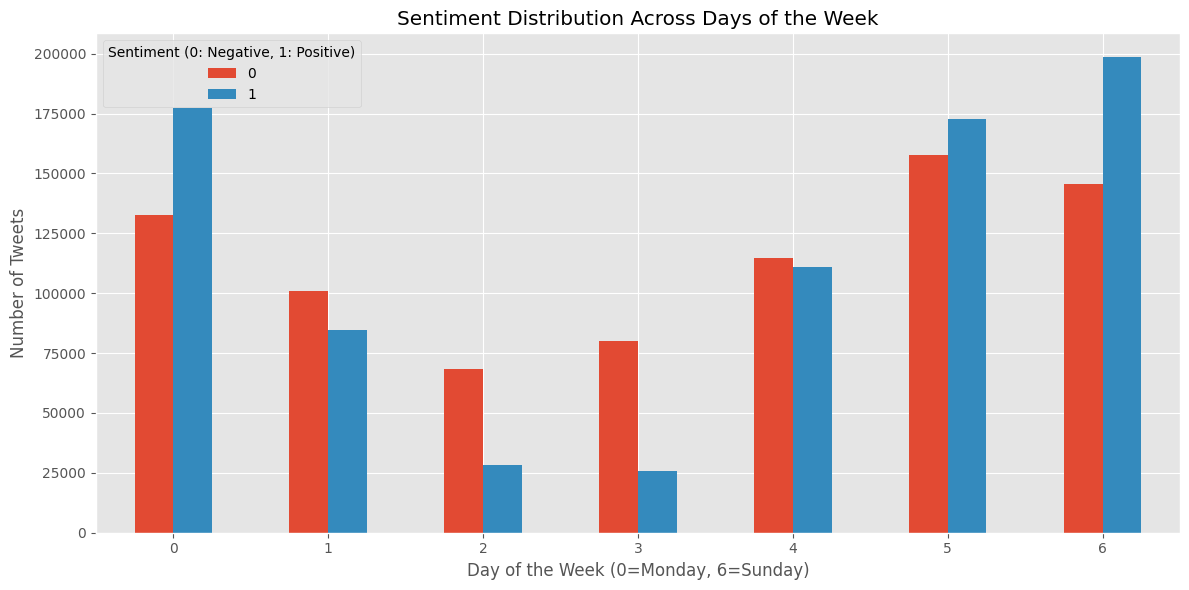

In [12]:
# Group by weekday and target, then count the occurrences
target_by_weekday = data.groupby(['weekday', 'target']).size().unstack(fill_value=0)

# Plot the distribution of sentiments over the days of the week
plt.figure(figsize=(12, 6))
target_by_weekday.plot(kind='bar', stacked=False, ax=plt.gca())
plt.title('Sentiment Distribution Across Days of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.legend(title='Sentiment (0: Negative, 1: Positive)')
plt.tight_layout()
plt.show()

# Users analysis

In [13]:
print(f'Number of unique users: {data["user"].nunique()}')
user_tweet_counts = data['user'].value_counts()

# Sort the counts in descending order and get the ranking
user_tweet_ranking = user_tweet_counts.sort_values(ascending=False)

# Display the top 10 users with the most tweets
print("Ranking of users by number of tweets (top 10):")
print(user_tweet_ranking.head(10))

Number of unique users: 659775
Ranking of users by number of tweets (top 10):
user
lost_dog           549
webwoke            345
tweetpet           309
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: count, dtype: int64


In [14]:
user_tweet_counts.describe()

count    659775.000000
mean          2.422230
std           4.702656
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: count, dtype: float64

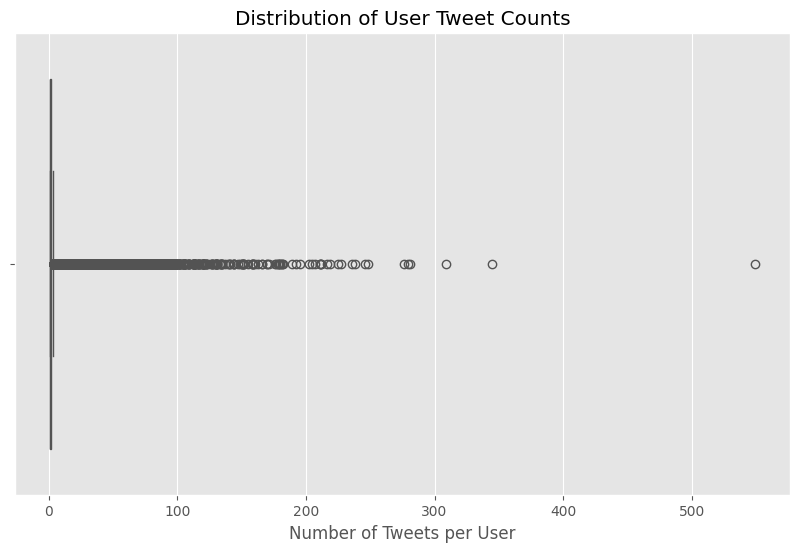

In [15]:
# Plot a box plot of user tweet counts to visualize the distribution
def plot_user_tweet_counts(counts=user_tweet_counts):
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=counts)
  plt.title('Distribution of User Tweet Counts')
  plt.xlabel('Number of Tweets per User')
  plt.show()

plot_user_tweet_counts()


Found 520 duplicate tweets for users with more than 200 tweets based on user and text.

Found 70 duplicate groups with the same target.
Removed 450 duplicate tweets with the same target.
Original dataframe shape: (1598127, 10)
Cleaned dataframe shape: (1597677, 10)
Boxplot after cleaning:


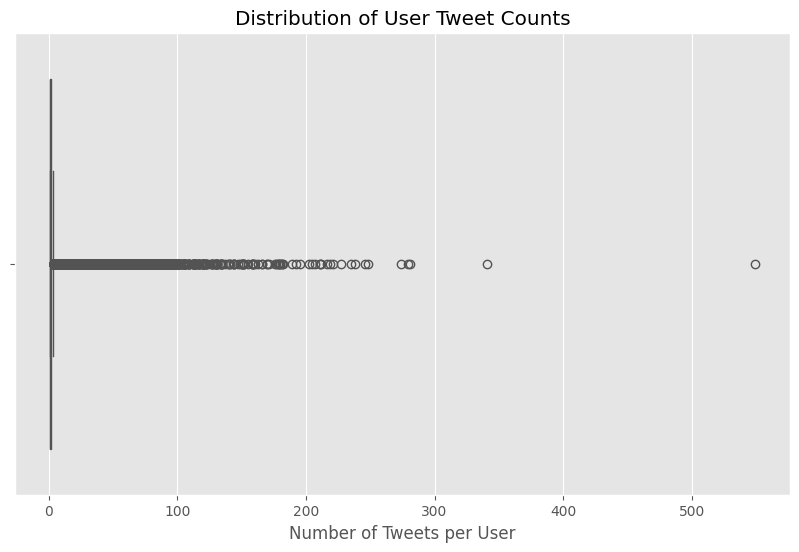

In [16]:
# Identify users with more than 200 tweets
users_with_many_tweets = user_tweet_counts[user_tweet_counts > 200].index

# Filter the dataframe to include only tweets from these users
df_many_tweets = data[data['user'].isin(users_with_many_tweets)].copy()

# Check for duplicates based on 'user' and 'text'
duplicates = df_many_tweets[df_many_tweets.duplicated(subset=['user', 'text'], keep=False)]

if not duplicates.empty:
    print(f"\nFound {len(duplicates)} duplicate tweets for users with more than 200 tweets based on user and text.")

    # Group by 'user' and 'text' and check if 'target' is the same or different within each group
    duplicate_groups = duplicates.groupby(['user', 'text'])
    duplicates_same_target = []
    duplicates_diff_target = []

    for name, group in duplicate_groups:
        if group['target'].nunique() == 1:
            duplicates_same_target.append(group)
        else:
            duplicates_diff_target.append(group)

    if duplicates_same_target:
        print(f"\nFound {len(duplicates_same_target)} duplicate groups with the same target.")
        # Concatenate the groups to form a DataFrame
        duplicates_same_target_df = pd.concat(duplicates_same_target)

        # Keep the first occurrence for duplicates with the same target
        df_many_tweets_cleaned = df_many_tweets.drop_duplicates(subset=['user', 'text', 'target'], keep='first')
        print(f"Removed {len(duplicates_same_target_df) - len(duplicates_same_target_df.drop_duplicates(subset=['user', 'text', 'target'], keep='first'))} duplicate tweets with the same target.")

        # Reintegrate the cleaned subset back into the original dataframe
        # First, remove the original rows for users with many tweets
        df_cleaned = data[~data['user'].isin(users_with_many_tweets)].copy()
        # Then, add the cleaned rows for users with many tweets
        df_cleaned = pd.concat([df_cleaned, df_many_tweets_cleaned], ignore_index=True)
        print(f"Original dataframe shape: {data.shape}")
        print(f"Cleaned dataframe shape: {df_cleaned.shape}")
        data = df_cleaned # Update the main dataframe

    if duplicates_diff_target:
        print(f"\nFound {len(duplicates_diff_target)} duplicate groups with different targets:")
        for i, group in enumerate(duplicates_diff_target):
            print(f"\nGroup {i+1}:")
            display(group[['user', 'text', 'target']])
        print("\nDuplicates with different targets are kept for further inspection.")
else:
    print("\nNo duplicate tweets found for users with more than 200 tweets based on user and text.")

print("Boxplot after cleaning:")
plot_user_tweet_counts(data['user'].value_counts())

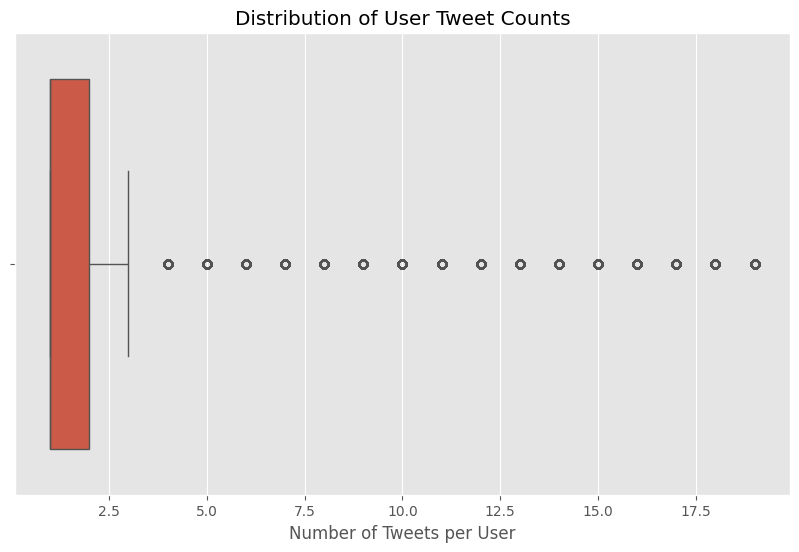

In [17]:
# Calculate tweet counts for users with fewer tweets to analyze most common behaviours
users_with_few_tweets = user_tweet_counts[user_tweet_counts < 20].index
tweet_counts_few_users = user_tweet_counts[users_with_few_tweets]

# Plot a box plot for users with less than 200 tweets
plot_user_tweet_counts(tweet_counts_few_users)

In [18]:
# Filter for users with more than 3 tweets
users_with_enough_tweets = data['user'].value_counts()
users_with_enough_tweets = users_with_enough_tweets[users_with_enough_tweets > 3].index
df_filtered_users = data[data['user'].isin(users_with_enough_tweets)].copy()

# Calculate sentiment counts per user
user_sentiment_counts = df_filtered_users.groupby(['user', 'target']).size().unstack(fill_value=0)

# Calculate total tweets per user
user_sentiment_counts['total_tweets'] = user_sentiment_counts[0] + user_sentiment_counts[1]

# Calculate proportion of positive and negative tweets
user_sentiment_counts['positive_proportion'] = (user_sentiment_counts[1] / user_sentiment_counts['total_tweets']) * 100
user_sentiment_counts['negative_proportion'] = (user_sentiment_counts[0] / user_sentiment_counts['total_tweets']) * 100

# Rank users by positive proportion (descending) and negative proportion (descending)
most_positive_users = user_sentiment_counts.sort_values(by='positive_proportion', ascending=False)
most_negative_users = user_sentiment_counts.sort_values(by='negative_proportion', ascending=False)

# Display the top 10 most positive users
print("Top 10 Most Positive Users (with > 3 tweets):")
print(most_positive_users[['positive_proportion', 'total_tweets']].head(10).round(2))

print("\n")

# Display the top 10 most negative users
print("Top 10 Most Negative Users (with > 3 tweets):")
print(most_negative_users[['negative_proportion', 'total_tweets']].head(10).round(2))

Top 10 Most Positive Users (with > 3 tweets):
target         positive_proportion  total_tweets
user                                            
SNRKing2                     100.0             5
EmilyyPettyy                 100.0             5
fetchmp3                     100.0            12
EmilyRankin17                100.0             4
feversoul                    100.0             5
lorangil                     100.0             7
fewarechosen                 100.0             5
fewing                       100.0             4
ffcreative                   100.0             4
EmilyUtratny                 100.0             6


Top 10 Most Negative Users (with > 3 tweets):
target           negative_proportion  total_tweets
user                                              
humbleorphans                  100.0             6
thatbeegirl                    100.0             4
MrD0nDaDa                      100.0             7
thatgirl_hannah                100.0             7
FreshDigits 

# Tweets analysis

In [19]:
eng_stopwords = nltk.corpus.stopwords.words('english')
# Simple clean and text tokenizer
def preprocess_text(text):
    # lower case and get rid off special characters
    # text = re.sub(r'[^\w\s]', '', text.lower())
    text = text.lower()
    # Tokenizer
    tokens = text.split()
    # delete stopwords
    tokens = [word for word in tokens if word not in eng_stopwords and len(word) > 1]
    return tokens


# Apply the cleaning function to the 'text' column
data['tokens'] = data['text'].apply(preprocess_text)

# Display the original and cleaned text for comparison
display(data[['text', 'tokens']].head())

,text,tokens
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D","[@switchfoot, http://twitpic.com/2y1zl, awww,, that's, bummer., shoulda, got, david, carr, third, day, it., ;d]"
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,"[upset, can't, update, facebook, texting, it..., might, cry, result, school, today, also., blah!]"
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,"[@kenichan, dived, many, times, ball., managed, save, 50%, rest, go, bounds]"
3,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]"
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.","[@nationwideclass, no,, behaving, all., i'm, mad., here?, can't, see, there.]"


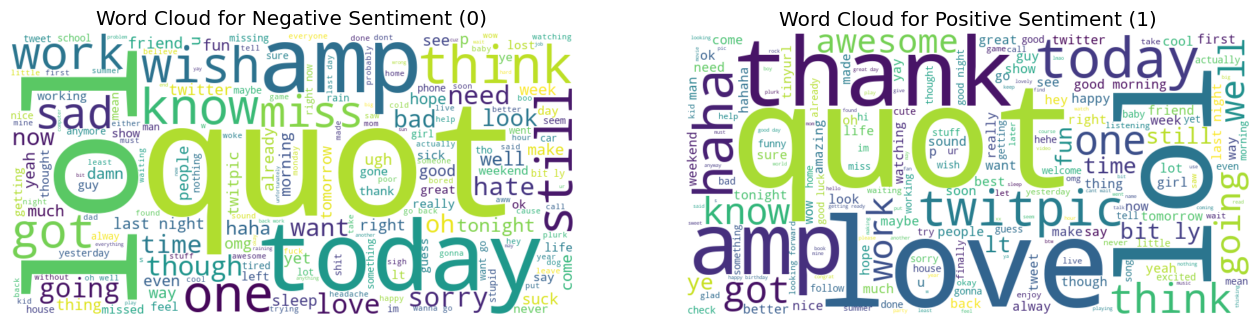

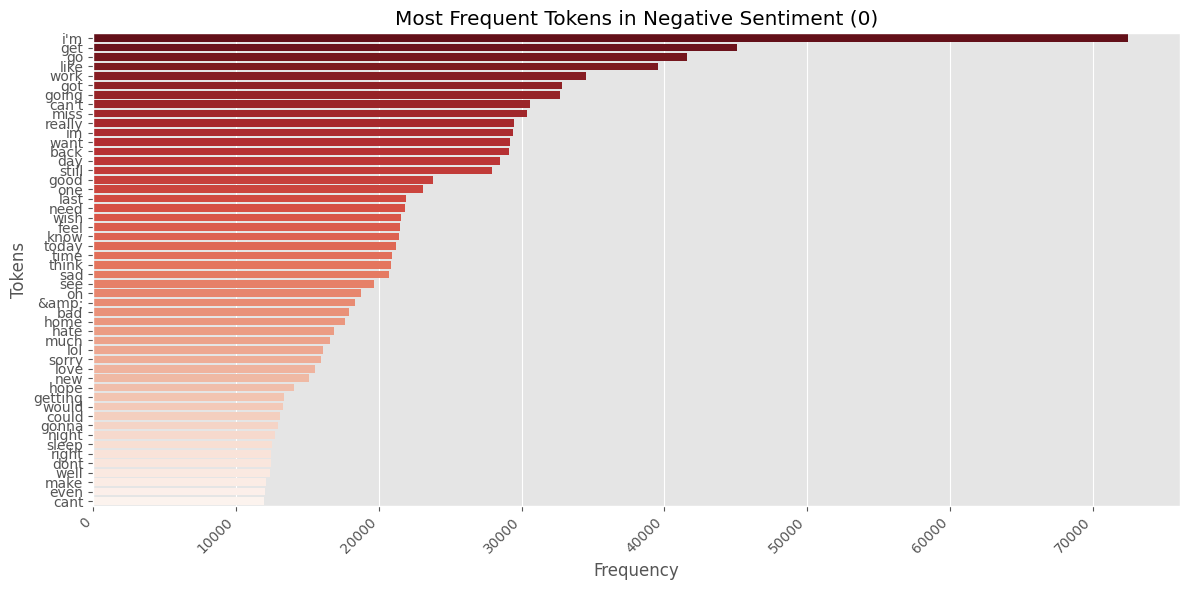

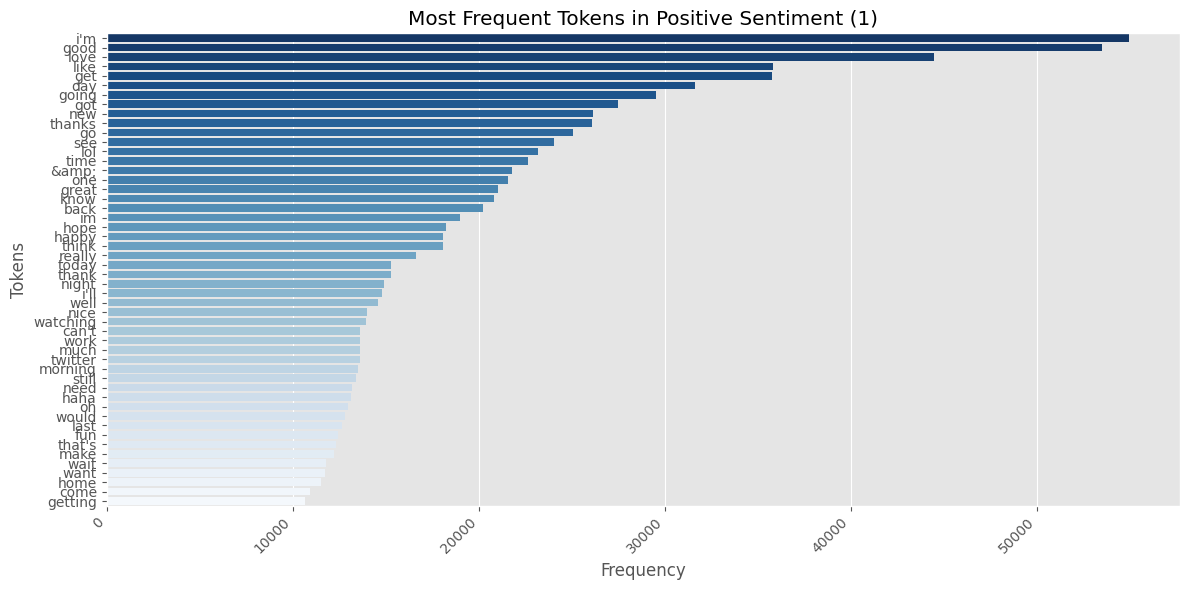

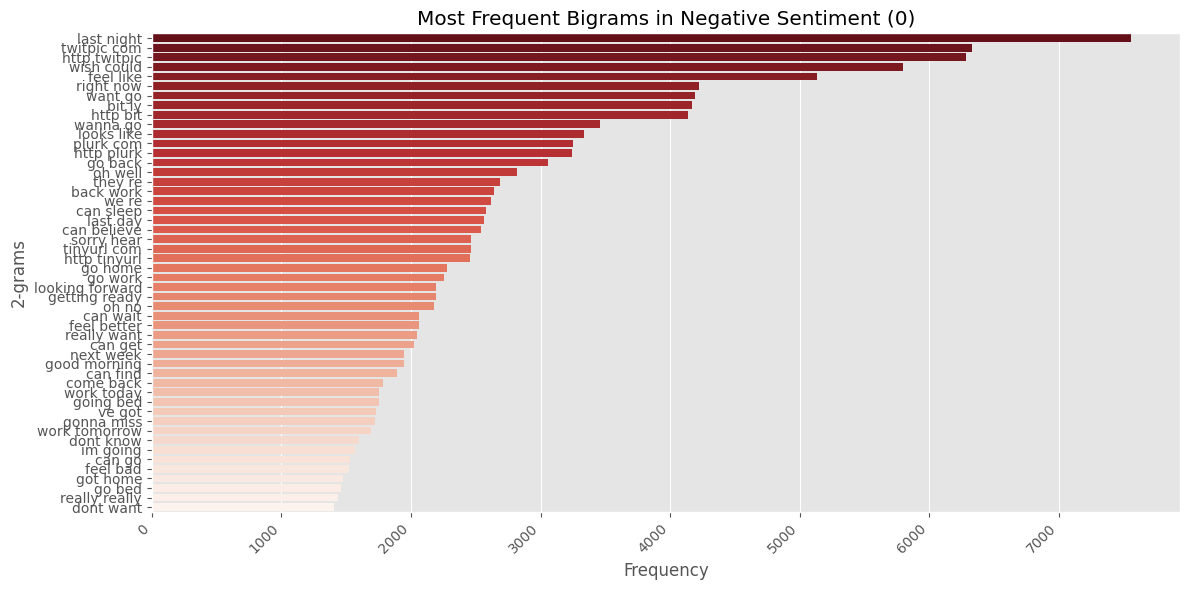

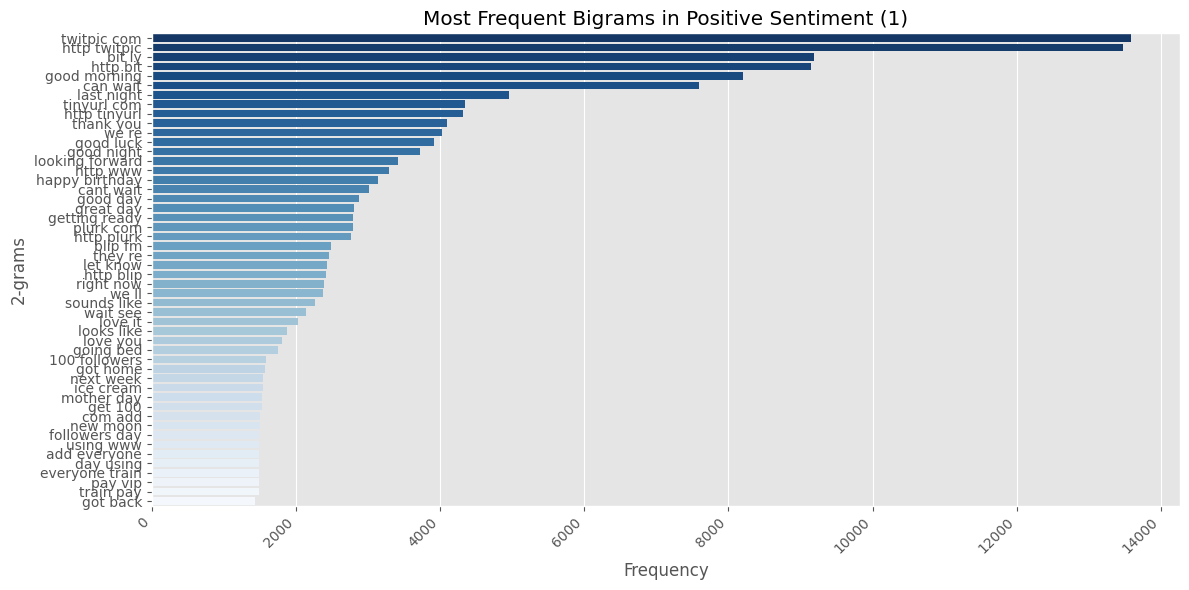

In [20]:
# Separate text based on sentiment
negative_tokens = [token for tokens_list in data[data['target'] == 0]['tokens'].dropna() for token in tokens_list]
positive_tokens = [token for tokens_list in data[data['target'] == 1]['tokens'].dropna() for token in tokens_list]

# --- Word Clouds ---
# Generate word clouds from tokens
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(" ".join(negative_tokens))
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(" ".join(positive_tokens))

# Plot word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment (0)')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment (1)')

plt.show()

# --- Token Counts (Unigrams) ---
# Function to plot most common tokens
def plot_most_common_tokens(tokens, title, palette, n=20):
    token_counts = Counter(tokens)
    most_common = token_counts.most_common(n)
    words, counts = zip(*most_common)

    plt.figure(figsize=(12, 6))
    sns.barplot(y=list(words), x=list(counts), palette=palette)
    plt.title(title)
    plt.ylabel("Tokens")
    plt.xlabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return most_common

# Plot most common tokens for negative sentiment
neg_most_common_tokens = plot_most_common_tokens(negative_tokens, 'Most Frequent Tokens in Negative Sentiment (0)', 'Reds_r', n=50)

# Plot most common tokens for positive sentiment
pos_most_common_tokens = plot_most_common_tokens(positive_tokens, 'Most Frequent Tokens in Positive Sentiment (1)', 'Blues_r', n=50)

# --- Bigram Counts ---
# Function to get and plot most common n-grams
def plot_most_common_ngrams(text_series, title, palette,  n=2, num_ngrams=20):
    # Join tokens back into strings for vectorizer
    text_strings = text_series.apply(lambda x: " ".join(x)).dropna()

    if len(text_strings) == 0:
        print(f"No text available for {title}")
        return

    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_matrix = vectorizer.fit_transform(text_strings)
    ngram_counts = ngram_matrix.sum(axis=0)
    ngram_freq = [(ngram, count) for ngram, count in zip(vectorizer.get_feature_names_out(), ngram_counts.tolist()[0])]

    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    most_common_ngrams = ngram_freq[:num_ngrams]

    ngrams, counts = zip(*most_common_ngrams)

    plt.figure(figsize=(12, 6))
    sns.barplot(
        y=list(ngrams),
        x=list(counts),
        palette=palette,
    )
    plt.title(title)
    plt.ylabel(f"{n}-grams")
    plt.xlabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return most_common_ngrams

# Plot most common bigrams for negative sentiment
neg_most_common_ngrams = plot_most_common_ngrams(data[data['target'] == 0]['tokens'], 'Most Frequent Bigrams in Negative Sentiment (0)', 'Reds_r', n=2, num_ngrams=50)

# Plot most common bigrams for positive sentiment
pos_most_common_ngrams = plot_most_common_ngrams(data[data['target'] == 1]['tokens'], 'Most Frequent Bigrams in Positive Sentiment (1)', 'Blues_r', n=2, num_ngrams=50)

In [21]:
# Get the set of words from the most common tokens for each sentiment
neg_words = set(word for word, freq in neg_most_common_tokens)
pos_words = set(word for word, freq in pos_most_common_tokens)

# Find the intersection of the two sets
common_words = neg_words.intersection(pos_words)

print(f"There are {len(common_words)} common words in the top 50 of each sentiment.")
print("Common words:", common_words)

# get rid of common words in the token column
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in common_words])

There are 36 common words in the top 50 of each sentiment.
Common words: {'today', 'back', 'good', 'think', 'want', 'go', "can't", 'last', '&amp;', 'love', 'one', 'hope', 'getting', 'still', 'time', 'make', 'work', 'got', 'night', 'home', "i'm", 'really', 'much', 'im', 'see', 'get', 'new', 'day', 'going', 'lol', 'know', 'would', 'like', 'well', 'oh', 'need'}



Descriptive Statistics for Text Length and Word Count by Target:
       text_length                                                       \
             count       mean        std  min   25%   50%    75%    max   
target                                                                    
0         799471.0  74.300908  36.706402  6.0  44.0  70.0  104.0  188.0   
1         798206.0  73.764907  36.052505  6.0  44.0  69.0  103.0  359.0   

       word_count                                                   
            count       mean       std  min  25%   50%   75%   max  
target                                                              
0        799471.0  13.587243  7.071265  1.0  8.0  13.0  19.0  57.0  
1        798206.0  12.759448  6.813721  1.0  7.0  12.0  18.0  64.0  


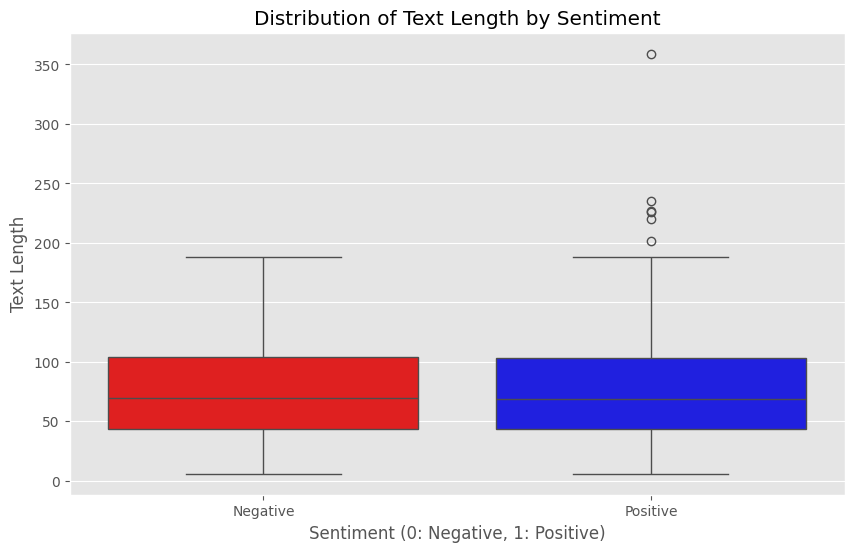

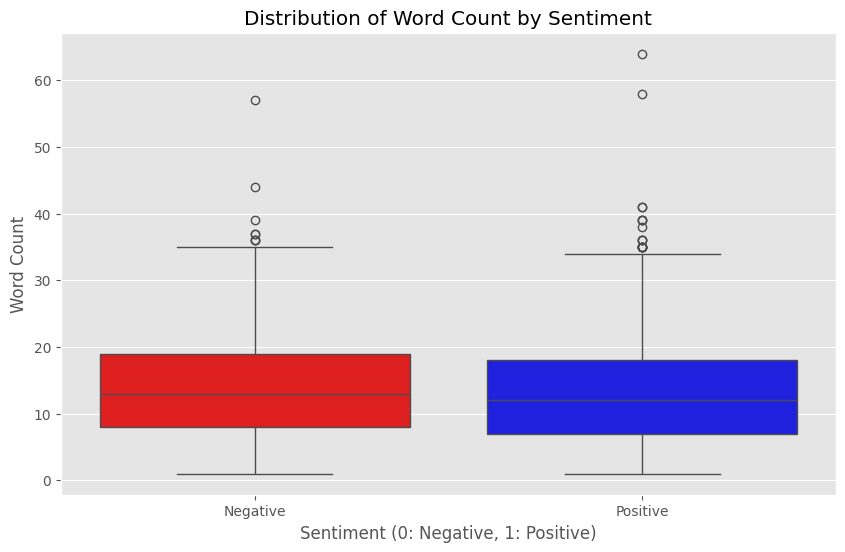

In [22]:
# Calculate length and number of words
data['text_length'] = data['text'].apply(len)
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

# Display descriptive statistics for length and word count by target
print("\nDescriptive Statistics for Text Length and Word Count by Target:")
print(data.groupby('target')[['text_length', 'word_count']].describe())

color_palette = {
    '0': 'red',
    '1': 'blue'
}

# Boxplot for text length by target
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='text_length', data=data, palette=color_palette)
plt.title('Distribution of Text Length by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Text Length')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Boxplot for word count by target
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='word_count', data=data, palette=color_palette)
plt.title('Distribution of Word Count by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

In [23]:
# Take a sample of 10000 tweets for each target
df_negative = data[data['target'] == 0].sample(n=10000, random_state=42)
df_positive = data[data['target'] == 1].sample(n=10000, random_state=42)

# Concatenate the samples
df_sample = pd.concat([df_negative, df_positive]).reset_index(drop=True)

# Shuffle the sample DataFrame
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows and the distribution of the target in the sample
display(df_sample.head())
print("\nDistribution of Sentiment in the Sample:")
print(df_sample["target"].value_counts())

,target,ids,date,user,text,year,month,day,hour,weekday,tokens,text_length,word_count
0,1,1684791314,2009-05-02 22:03:36,UtahPersonals,"W4M: Nice, tender educated woman (Salt Lake City) 20yr http://tinyurl.com/dgev67",2009,5,2,22,5,"[w4m:, nice,, tender, educated, woman, (salt, lake, city), 20yr, http://tinyurl.com/dgev67]",81,10
1,0,2266239922,2009-06-21 08:09:24,shyuanie,Fervently praying for an extension,2009,6,21,8,6,"[fervently, praying, extension]",37,5
2,0,2061244588,2009-06-06 20:28:14,DaRiddler352,@MarquelHurst if only I had money,2009,6,6,20,5,"[@marquelhurst, money]",34,6
3,0,1966077763,2009-05-29 17:04:57,baovo,Love how my printer decided to print all my blacks all marbled - 1hr before an interview for new work this morning.,2009,5,29,17,4,"[printer, decided, print, blacks, marbled, 1hr, interview, morning.]",116,22
4,1,1963093874,2009-05-29 12:11:35,MeganLucyOx,chocolate fudge cake,2009,5,29,12,4,"[chocolate, fudge, cake]",21,3



Distribution of Sentiment in the Sample:
target
1    10000
0    10000
Name: count, dtype: int64


For elements that contribute to the style or emphasis within the text (capital letters, exclamations, interrogations, and ellipsis), ratios are generally more informative as they account for tweet length.

For elements that represent distinct entities or actions (emojis, hashtags, mentions, and URLs), simple counts are often more appropriate as they reflect the number of instances of these specific items.

In [24]:
# Feature Engineering: Character Analysis
def char_analysis(text):
    if isinstance(text, str):
        capital_letters = sum(1 for char in text if char.isupper())
        exclamations = text.count('!')
        interrogations = text.count('?')
        ellipsis_count = text.count('...')

        # Define regex patterns for different emoji types
        positive_emoji_pattern = re.compile(r'[\\U0001F600-\\U0001F60A\\U0001F60D\\U0001F923\\U00002764\\U0001F44D]')
        negative_emoji_pattern = re.compile(r'[\\U0001F61E-\\U0001F62D\\U0001F44E]')

        # Count occurrences
        positive_emojis = len(positive_emoji_pattern.findall(text))
        negative_emojis = len(negative_emoji_pattern.findall(text))
        hastags_count = text.count('#')
        mentions_count = text.count('@')
        urls_count = text.count('http')

        total_chars = len(text)
        return pd.Series({
            'capital_ratio': round((capital_letters / total_chars) * 100, 2) if total_chars > 0 else 0,
            'exclamations_ratio': round((exclamations / total_chars) * 100, 2) if total_chars > 0 else 0,
            'interrogations_ratio': round((interrogations / total_chars) * 100, 2) if total_chars > 0 else 0,
            'ellipsis_ratio': round((ellipsis_count / total_chars) * 100, 2) if total_chars > 0 else 0,
            'positive_emojis_counts': positive_emojis,
            'negative_emojis_counts': negative_emojis,
            'hastags_counts': hastags_count,
            'mentions_counts': mentions_count,
            'urls_counts': urls_count,
        })

    else:
        return pd.Series({
            'capital_ratio': 0,
            'exclamations_ratio': 0,
            'interrogations_ratio': 0,
            'ellipsis_ratio': 0,
            'emojis_counts': 0,
            'positive_emojis_counts': 0,
            'negative_emojis_counts': 0,
            'hastags_counts': 0,
            'mentions_counts': 0,
            'urls_counts': 0,
        })


def compare_targets(df: pd.DataFrame):
    """ Compare character features between positive and negative targets in the DataFrame.
    This function applies character analysis to the 'text' column of the DataFrame,
    and calculates the mean ratio for each feature grouped by target.
    Args:
        df (pd.DataFrame): The DataFrame containing the 'text' column and 'target' column.
    Returns:
    """
    # Group by target and calculate the mean ratio for each feature
    features = [
        "capital_ratio",
        "exclamations_ratio",
        "interrogations_ratio",
        "ellipsis_ratio",
        "positive_emojis_counts",
        "negative_emojis_counts",
        "hastags_counts",
        "mentions_counts",
        "urls_counts",
    ]

    # Apply analysis only if columns don't already exist to prevent duplication
    if 'capital_ratio' not in df.columns:
        df_char_analysis = df['text'].apply(char_analysis)
        df_analysis = pd.concat([df, df_char_analysis], axis=1)

    # Group by target and calculate the mean for each feature
    char_analysis_by_target = df_analysis.groupby("target")[features].mean().round(4).reset_index()

    # Create a DataFrame for the character analysis by target
    analysis_df = pd.DataFrame(index=features, columns=['negative_mean', 'positive_mean', 'difference'])

    for feature in features:
        neg_mean = char_analysis_by_target[char_analysis_by_target["target"] == 0][
            feature
        ].mean()
        pos_mean = char_analysis_by_target[char_analysis_by_target["target"] == 1][
            feature
        ].mean()
        if neg_mean != 0:
            difference = (pos_mean - neg_mean) / abs(neg_mean) * 100
        else:
            # If neg_target is 0, represent infinite growth as a large, fixed percentage (e.g., 1000%)
            # or set to 0 if pos_target is also 0.
            difference = float('inf') if pos_mean != 0 else 0

        print(f"Feature: {feature}, Negative Target Mean: {neg_mean}, Positive Target Mean: {pos_mean}")
        analysis_df.loc[feature, "negative_mean"] = neg_mean
        analysis_df.loc[feature, 'positive_mean'] = pos_mean
        analysis_df.loc[feature, 'difference'] = difference

        sorted_analysis_df = analysis_df.sort_values(by='difference', ascending=False)

    return char_analysis_by_target, sorted_analysis_df


# Execution
target_stats, sorted_analysis_df = compare_targets(df=df_sample)
# Display the character analysis by target
print("Mean Feature Values by Sentiment:")
display(target_stats)
# Display the sorted analysis DataFrame
print("\\nRelative Difference Between Sentiments:")
display(sorted_analysis_df)

Feature: capital_ratio, Negative Target Mean: 4.3291, Positive Target Mean: 4.9717
Feature: exclamations_ratio, Negative Target Mean: 0.682, Positive Target Mean: 1.0092
Feature: interrogations_ratio, Negative Target Mean: 0.1974, Positive Target Mean: 0.2318
Feature: ellipsis_ratio, Negative Target Mean: 0.2967, Positive Target Mean: 0.203
Feature: positive_emojis_counts, Negative Target Mean: 4.2381, Positive Target Mean: 4.9938
Feature: negative_emojis_counts, Negative Target Mean: 2.9478, Positive Target Mean: 3.2939
Feature: hastags_counts, Negative Target Mean: 0.0253, Positive Target Mean: 0.0289
Feature: mentions_counts, Negative Target Mean: 0.4024, Positive Target Mean: 0.5998
Feature: urls_counts, Negative Target Mean: 0.03, Positive Target Mean: 0.0621
Mean Feature Values by Sentiment:


,target,capital_ratio,exclamations_ratio,interrogations_ratio,ellipsis_ratio,positive_emojis_counts,negative_emojis_counts,hastags_counts,mentions_counts,urls_counts
0,0,4.3291,0.6820,0.1974,0.2967,4.2381,2.9478,0.0253,0.4024,0.0300
1,1,4.9717,1.0092,0.2318,0.2030,4.9938,3.2939,0.0289,0.5998,0.0621


\nRelative Difference Between Sentiments:


,negative_mean,positive_mean,difference
urls_counts,0.03,0.0621,107.0
mentions_counts,0.4024,0.5998,49.055666
exclamations_ratio,0.682,1.0092,47.97654
positive_emojis_counts,4.2381,4.9938,17.831104
interrogations_ratio,0.1974,0.2318,17.426545
capital_ratio,4.3291,4.9717,14.843732
hastags_counts,0.0253,0.0289,14.229249
negative_emojis_counts,2.9478,3.2939,11.740959
ellipsis_ratio,0.2967,0.203,-31.580721


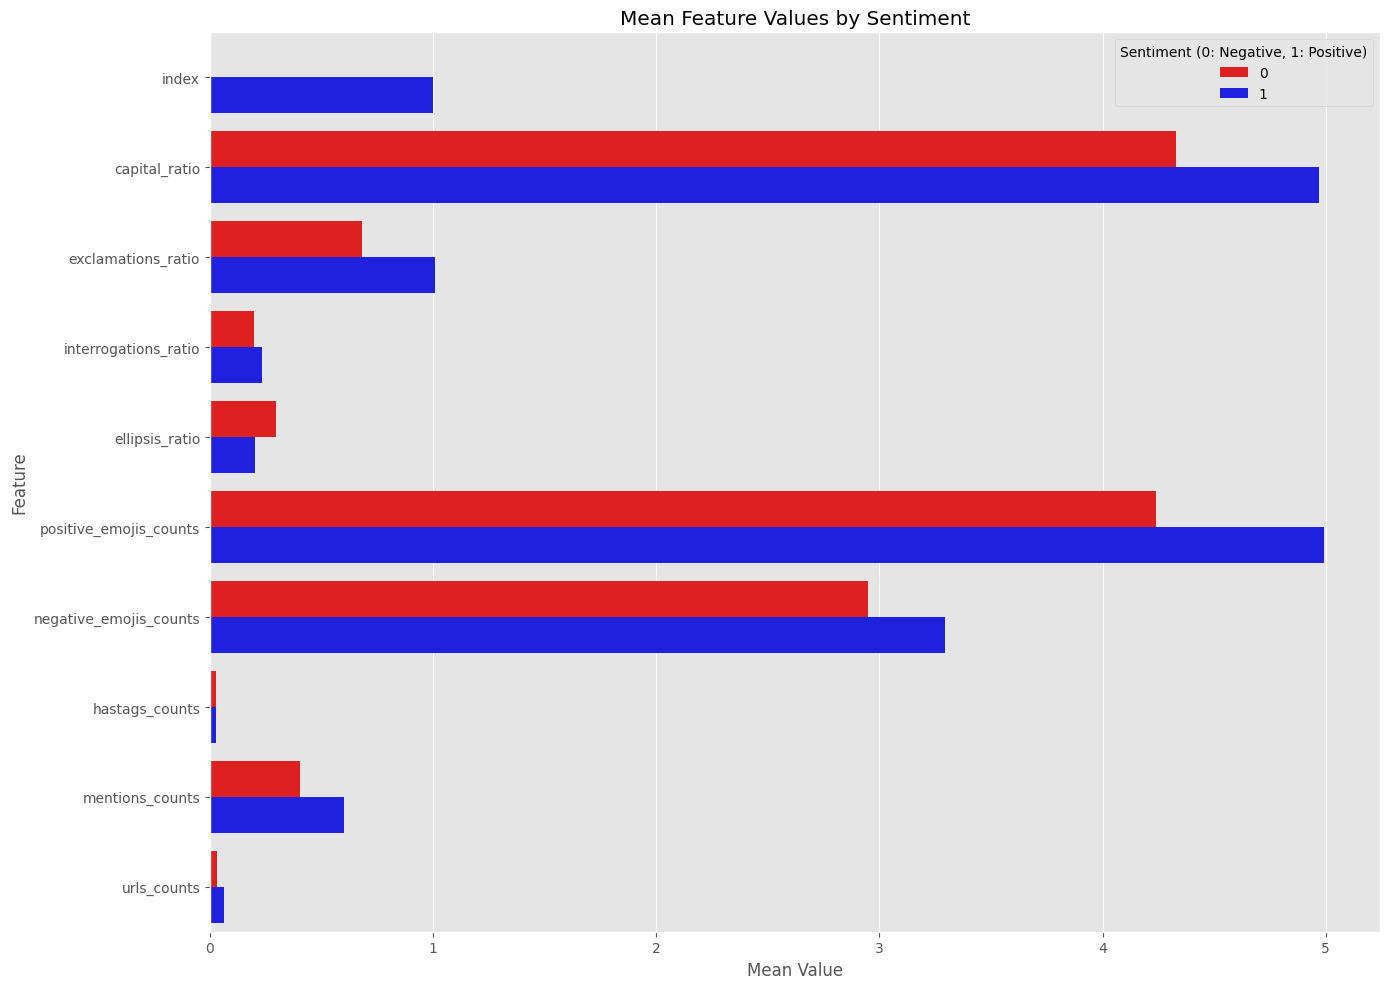

In [25]:
# Reshape the data for plotting
plot_df = target_stats.reset_index().melt(id_vars='target', var_name='feature', value_name='mean_value')
plot_df['target'] = plot_df['target'].astype(str)

# Plot the data
plt.figure(figsize=(14, 10))
sns.barplot(x='mean_value', y='feature', hue='target', data=plot_df, palette=color_palette, orient='h')

plt.title('Mean Feature Values by Sentiment')
plt.xlabel('Mean Value')
plt.ylabel('Feature')
plt.legend(title='Sentiment (0: Negative, 1: Positive)')
plt.tight_layout()
plt.show()

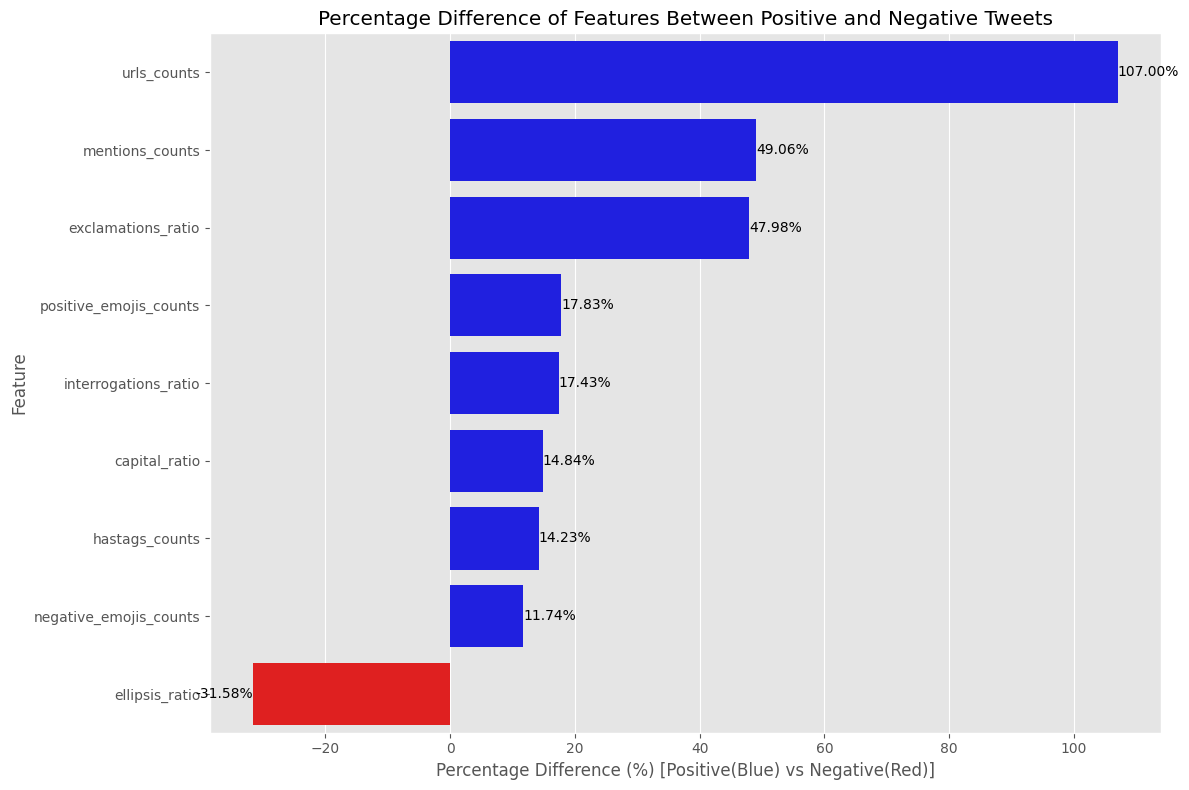

In [26]:
# Convert the 'difference' column to a numeric type for plotting
# sorted_analysis_df["difference"] = pd.to_numeric(sorted_analysis_df["difference"])

# Create a color list based on the sign of the difference
colors = ["blue" if x > 0 else "red" for x in sorted_analysis_df["difference"]]

# Plot the differences
plt.figure(figsize=(12, 8))
sns.barplot(
    x="difference",
    y=sorted_analysis_df.index,
    data=sorted_analysis_df,
    palette=colors,
    orient="h",
)

# Add text, titles and labels
for index, value in enumerate(sorted_analysis_df["difference"]):
    plt.text(
        value,
        index,
        f"{value:.2f}%",
        color="black",
        va="center",
        ha="left" if value > 0 else "right",
    )
plt.title("Percentage Difference of Features Between Positive and Negative Tweets")
plt.xlabel("Percentage Difference (%) [Positive(Blue) vs Negative(Red)]")
plt.ylabel("Feature")

# Ensure the layout is clean
plt.tight_layout()

# Show the plot
plt.show()

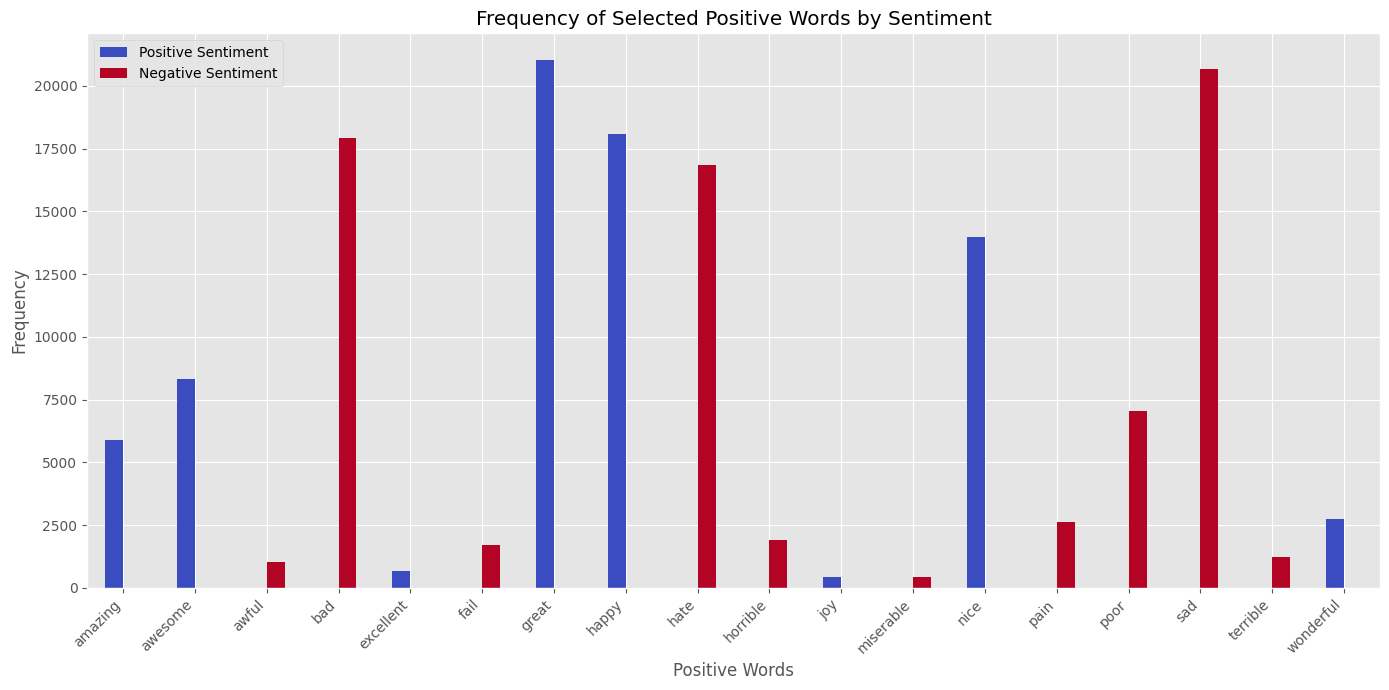

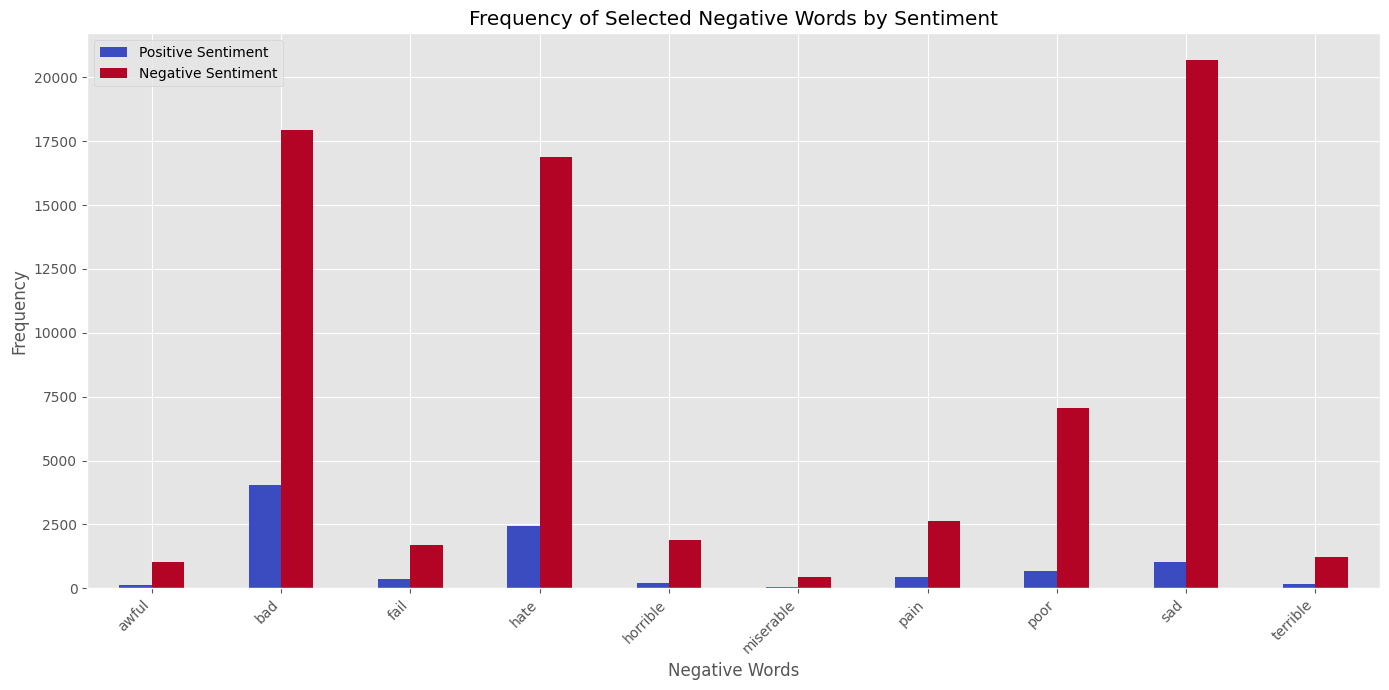

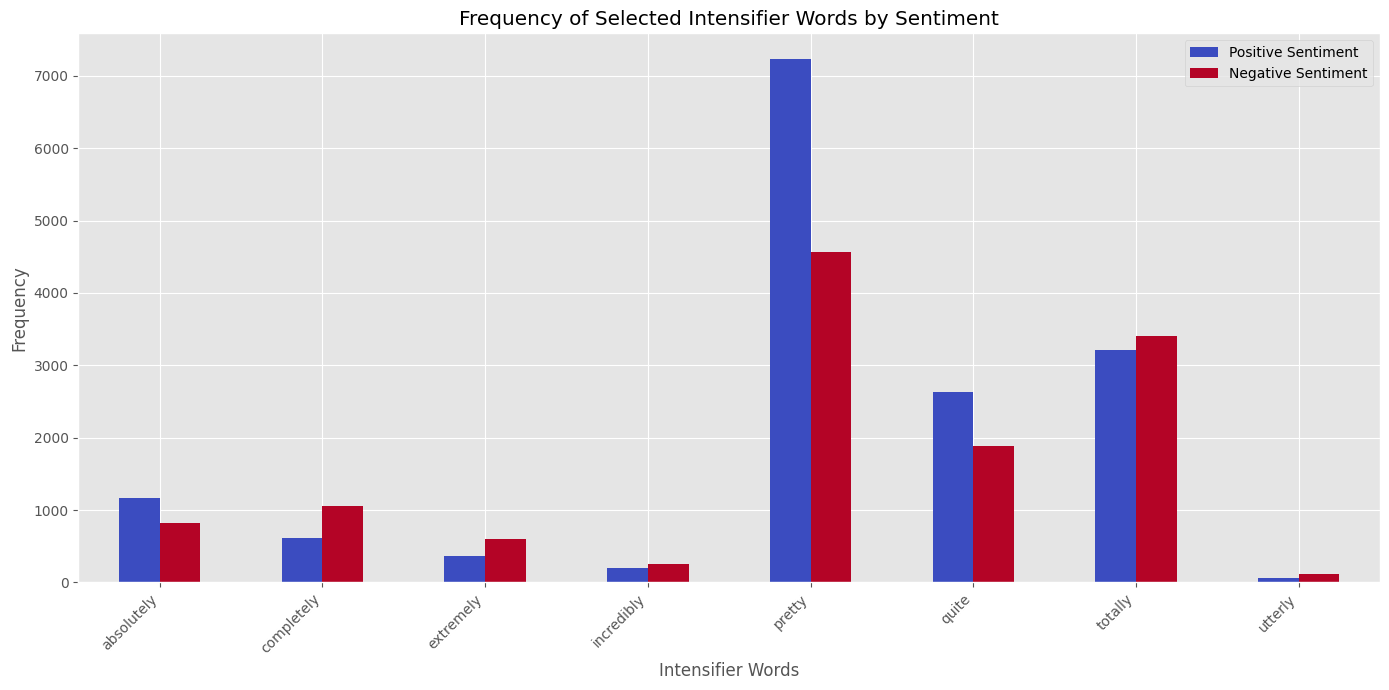

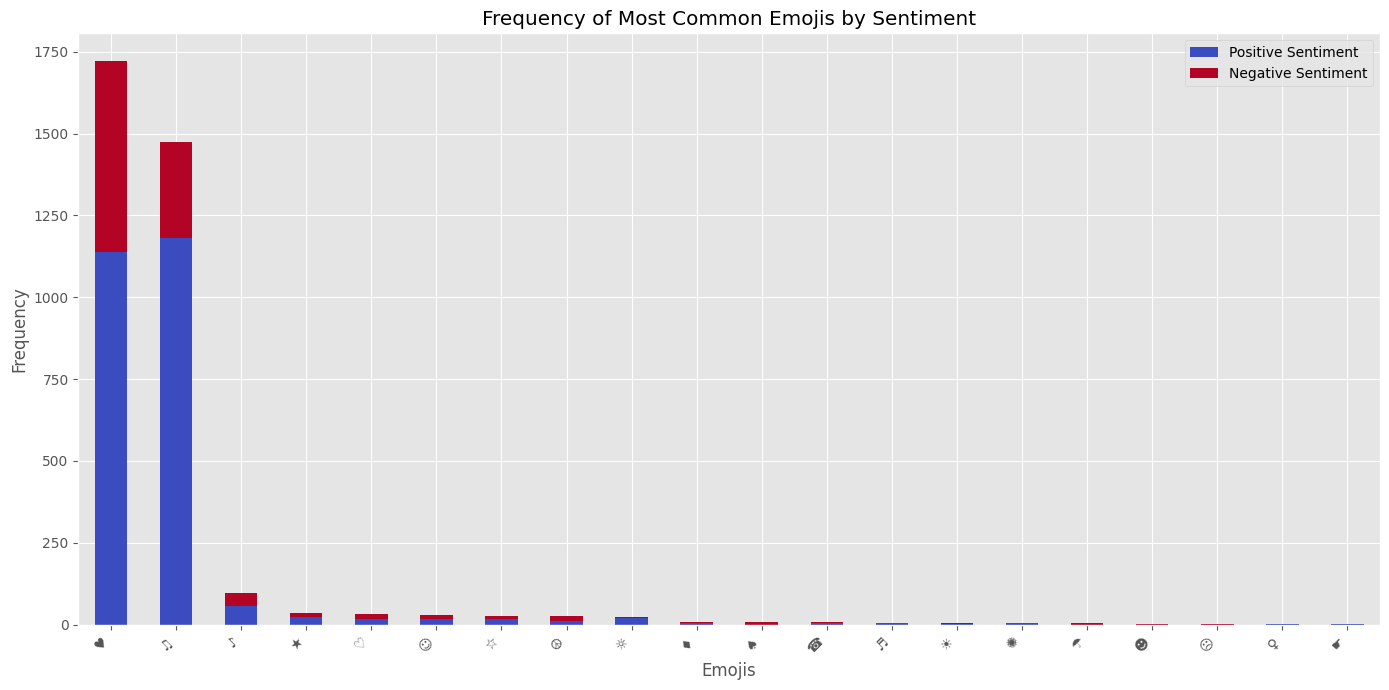

In [27]:
# Define lists of positive, negative, and intensifier words
positive_words = ['good', 'great', 'love', 'happy', 'awesome', 'nice', 'wonderful', 'excellent', 'amazing', 'joy']
negative_words = ['bad', 'terrible', 'hate', 'sad', 'awful', 'poor', 'horrible', 'miserable', 'pain', 'fail']
intensifiers = ['very', 'really', 'so', 'extremely', 'incredibly', 'quite', 'pretty', 'absolutely', 'totally', 'completely', 'utterly']

# Compile regex for emojis (more specific regex might be needed for comprehensive coverage)
# Basic regex for common emojis and some common emoji characters
emoji_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U00002702-\U000027B0\U00002600-\U000026FF\U0000FE00-\U0000FE0F\U0001F1E0-\U0001F1FF]')

# Function to count specific tokens in a list of tokens
def count_specific_tokens(tokens_list, word_list):
    token_counts = Counter([token for tokens in tokens_list for token in tokens if token in word_list])
    return token_counts

# Function to count emojis in raw text
def count_emojis_in_text(text_series):
    all_emojis = []
    for text in text_series.dropna():
        all_emojis.extend(emoji_pattern.findall(text))
    return Counter(all_emojis)


# Count positive, negative, and intensifier words in positive and negative tweets
positive_word_counts_pos = count_specific_tokens(data[data['target'] == 1]['tokens'], positive_words)
negative_word_counts_pos = count_specific_tokens(data[data['target'] == 1]['tokens'], negative_words)
intensifier_counts_pos = count_specific_tokens(data[data['target'] == 1]['tokens'], intensifiers)

positive_word_counts_neg = count_specific_tokens(data[data['target'] == 0]['tokens'], positive_words)
negative_word_counts_neg = count_specific_tokens(data[data['target'] == 0]['tokens'], negative_words)
intensifier_counts_neg = count_specific_tokens(data[data['target'] == 0]['tokens'], intensifiers)

# Count emojis in positive and negative tweets (using raw text)
emoji_counts_pos = count_emojis_in_text(data[data['target'] == 1]['text'])
emoji_counts_neg = count_emojis_in_text(data[data['target'] == 0]['text'])

# --- Visualization ---

# Function to plot token counts
def plot_token_counts(pos_counts, neg_counts, title, token_type):
    # Combine counts and create a DataFrame for easier plotting
    all_tokens = set(pos_counts.keys()).union(set(neg_counts.keys()))
    data = {token: [pos_counts.get(token, 0), neg_counts.get(token, 0)] for token in all_tokens}
    plot_df = pd.DataFrame.from_dict(data, orient='index', columns=['Positive Sentiment', 'Negative Sentiment'])
    plot_df = plot_df.sort_index() # Sort alphabetically for consistency

    if plot_df.empty:
        print(f"No {token_type} found.")
        return

    plot_df.plot(kind='bar', figsize=(14, 7), colormap='coolwarm')
    plt.title(title)
    plt.xlabel(token_type)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot positive word counts
plot_token_counts(positive_word_counts_pos, negative_word_counts_neg, 'Frequency of Selected Positive Words by Sentiment', 'Positive Words')

# Plot negative word counts
plot_token_counts(negative_word_counts_pos, negative_word_counts_neg, 'Frequency of Selected Negative Words by Sentiment', 'Negative Words')

# Plot intensifier counts
plot_token_counts(intensifier_counts_pos, intensifier_counts_neg, 'Frequency of Selected Intensifier Words by Sentiment', 'Intensifier Words')

# Plot emoji counts (plot the top N most frequent emojis in total)
def plot_emoji_counts(pos_counts, neg_counts, title, num_emojis=20):
    all_emoji_counts = Counter(pos_counts) + Counter(neg_counts)
    most_common_emojis = all_emoji_counts.most_common(num_emojis)

    if not most_common_emojis:
        print("No emojis found.")
        return

    emojis, total_counts = zip(*most_common_emojis)

    # Prepare data for stacked bar chart
    emoji_data = {emoji: [pos_counts.get(emoji, 0), neg_counts.get(emoji, 0)] for emoji in emojis}
    plot_df = pd.DataFrame.from_dict(emoji_data, orient='index', columns=['Positive Sentiment', 'Negative Sentiment'])

    plot_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='coolwarm')
    plt.title(title)
    plt.xlabel('Emojis')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_emoji_counts(emoji_counts_pos, emoji_counts_neg, 'Frequency of Most Common Emojis by Sentiment')

# Strategy

From This analysis, we can conclude that :
- URL, mentions, hashtags and exclamation marks are mostly used for positive tweets
- ellipsis are mostly used in negative tweets

For this reason, it seems to be interesting to keep the information to feed our models.

# Preprocessing

## feature engineering

In [42]:
df = data.copy()
display(df['target'].value_counts())

target
0    799471
1    798206
Name: count, dtype: int64

In [33]:
def preprocess_tweets(tweet:str='text')-> tuple:
    """Preprocess the tweets by uniformazing URLs and mentions and create numerical features to count urls, hashtags, mentions, question & exclamation marks, ellipsis.
    Args:
        df (pd.DataFrame): The DataFrame containing the tweets.
        col (str): The column name containing the tweets.
    Returns:
        tuple: A tuple containing a dataframe with processed tweets and a dictionary with feature counts.
    """
    stopwords = nltk.corpus.stopwords.words('english')
    limited_stopwords = set(stopwords) - {'not', 'no', 'nor', 'don', "don't", 'doesn', "doesn't", 'didn', "didn't", 'isn', "isn't", 'aren', "aren't", 'wasn', "wasn't", 'weren', "weren't", 'shouldn', "shouldn't", 'none', 'never', 'nothing', 'nobody', 'nowhere', 'neither'}
    processed_tweet = tweet

    # URLs
    processed_tweet = re.sub(r'http\S+|https\S+', '<url>', processed_tweet)
    # mentions
    processed_tweet = re.sub(r'@\w+', '<mention>', processed_tweet)
    # Seperate hashtags from words
    processed_tweet = re.sub(r'#(\w+)', r'# \1', processed_tweet)

    # Create features counts
    features_counts = {
        "url_count": processed_tweet.count("<url>"),
        "mention_count": processed_tweet.count("<mention>"),
        "hashtag_count": processed_tweet.count("#"),
        "question_count": processed_tweet.count("?"),
        "exclamation_count": processed_tweet.count("!"),
        "ellipsis_count": processed_tweet.count("..."),
        "capital_count": (
            sum(1 for char in processed_tweet if char.isupper()) / len(processed_tweet)
            if len(processed_tweet) > 0
            else 0
        ),
    }

    tokens = processed_tweet.lower().split()
    tokens_to_keep = ['<url>', '<mention>', '#']
    tokens = [token for token in tokens if token not in limited_stopwords and len(token) > 1 or token in tokens_to_keep]
    # Get rid of special characters except for those in tokens_to_keep and for exclamation marks, question marks and ellipsis
    processed_tweet = ' '.join(tokens)
    processed_tweet = re.sub(r'[^a-zA-Z0-9\s#<url><mention>!?]', '', processed_tweet)
    # Get rid of multiple spaces
    processed_tweet = re.sub(r'\s+', ' ', processed_tweet).strip()

    return processed_tweet, features_counts

In [43]:
# Enable tqdm for pandas operations
tqdm.pandas(desc="Processing tweets")

# Apply the preprocessing function to each tweet
# This will return a series of tuples, where each tuple contains the processed text and a dictionary of features
processed_results = df["text"].progress_apply(preprocess_tweets)

# Unpack the tuples into two separate series
df["processed_tweets"] = processed_results.apply(lambda x: x[0])
tqdm.pandas(desc="Creating new features")
features_df = processed_results.progress_apply(lambda x: pd.Series(x[1]))

# Concatenate the new feature columns with the original dataframe
processed_df = pd.concat([df, features_df], axis=1)

# Display the first few rows with the new features
display(processed_df.head())

Processing tweets:   0%|          | 0/1597677 [00:00<?, ?it/s]

Creating new features:   0%|          | 0/1597677 [00:00<?, ?it/s]

,target,ids,date,user,text,year,month,day,hour,weekday,tokens,text_length,word_count,processed_tweets,url_count,mention_count,hashtag_count,question_count,exclamation_count,ellipsis_count,capital_count
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009,4,6,22,0,"[@switchfoot, http://twitpic.com/2y1zl, awww,, that's, bummer., shoulda, david, carr, third, it., ;d]",115,19,<mention> <url> awww thats bummer shoulda got david carr third day it d,1.0,1.0,0.0,0.0,0.0,0.0,0.074468
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009,4,6,22,0,"[upset, update, facebook, texting, it..., might, cry, result, school, also., blah!]",111,21,upset cant update facebook texting it might cry result school today also blah!,0.0,0.0,0.0,0.0,1.0,1.0,0.027027
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009,4,6,22,0,"[@kenichan, dived, many, times, ball., managed, save, 50%, rest, bounds]",89,18,<mention> dived many times ball managed save 50 rest go bounds,0.0,1.0,0.0,0.0,0.0,0.0,0.033708
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,2009,4,6,22,0,"[whole, body, feels, itchy, fire]",47,10,whole body feels itchy like fire,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009,4,6,22,0,"[@nationwideclass, no,, behaving, all., mad., here?, there.]",111,21,<mention> no not behaving all im mad here? cant see there,0.0,1.0,0.0,1.0,0.0,0.0,0.009615


In [45]:
neg = processed_df[processed_df['target'] == 0].sample(n=100, random_state=42)
pos = processed_df[processed_df['target'] == 1].sample(n=100, random_state=42)
# Display a sample of negative and positive tweets with their processed text and features
print("\nSample of Negative Tweets:")
display(neg.tail(10))
print("\nSample of Positive Tweets:")
display(pos.tail(10))


Sample of Negative Tweets:


,target,ids,date,user,text,year,month,day,hour,weekday,tokens,text_length,word_count,processed_tweets,url_count,mention_count,hashtag_count,question_count,exclamation_count,ellipsis_count,capital_count
495312,0,2185888848,2009-06-15 18:03:07,JellieBraden,"@missmotorcade thanks, I have a house full of kids and feel all alone,it sucks",2009,6,15,18,0,"[@missmotorcade, thanks,, house, full, kids, feel, alone,it, sucks]",79,14,<mention> thanks house full kids feel aloneit sucks,0.0,1.0,0.0,0.0,0.0,0.0,0.013514
271332,0,1990227622,2009-06-01 04:16:04,Amanda2409,Good morning twppl..the count down to the end of school begins.,2009,6,1,4,0,"[morning, twppl..the, count, end, school, begins.]",64,11,good morning twpplthe count end school begins,0.0,0.0,0.0,0.0,0.0,0.0,0.015625
550639,0,2203501130,2009-06-16 23:52:53,oohlalamama,today its another day and i will be ready for what's next being lonely its painful,2009,6,16,23,1,"[another, ready, what's, next, lonely, painful]",83,16,today another day ready whats next lonely painful,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
161377,0,1957491235,2009-05-29 00:40:05,ancientbruises,damn i missed @xsparkage's blogtv i hope it was funsies?,2009,5,29,0,4,"[damn, missed, @xsparkage's, blogtv, funsies?]",57,10,damn missed <mention>s blogtv hope funsies?,0.0,1.0,0.0,1.0,0.0,0.0,0.000000
483880,0,2181364147,2009-06-15 11:43:42,Maximilus,@MoMaalim They will. They will.,2009,6,15,11,0,"[@momaalim, will., will.]",32,5,<mention> will will,0.0,1.0,0.0,0.0,0.0,0.0,0.062500
102238,0,1795225448,2009-05-14 07:23:24,jessdel1980,"@askdavis About her voluntary layoff? Yes! *waaaah* Very admirable of her, sad for us though",2009,5,14,7,3,"[@askdavis, voluntary, layoff?, yes!, *waaaah*, admirable, her,, sad, us, though]",94,15,<mention> voluntary layoff? yes! waaaah admirable her sad us though,0.0,1.0,0.0,1.0,1.0,0.0,0.031915
216364,0,1975915703,2009-05-30 16:10:45,mzleenabishes,@justmean i been hungry.. havent eaten all day,2009,5,30,16,5,"[@justmean, hungry.., havent, eaten]",48,8,<mention> hungry havent eaten day,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
170354,0,1963137092,2009-05-29 12:15:35,leeanne81,M.I.A?PJ?Beasties?Thievery?Volta?Bat4Lashes?BandOfHorses? I enjoy this line-up: http://bit.ly/16lUgX Too bad it's in San Fran,2009,5,29,12,4,"[m.i.a?pj?beasties?thievery?volta?bat4lashes?bandofhorses?, enjoy, line-up:, http://bit.ly/16lugx, bad, san, fran]",126,12,mia?pj?beasties?thievery?volta?bat4lashes?bandofhorses? enjoy lineup <url> bad san fran,1.0,0.0,0.0,7.0,0.0,0.0,0.153153
675440,0,2248823175,2009-06-19 21:14:35,nicole8yourface,I just wanna go home already camp isn't fun anymore.,2009,6,19,21,4,"[wanna, already, camp, fun, anymore.]",53,10,wanna go home already camp isnt fun anymore,0.0,0.0,0.0,0.0,0.0,0.0,0.018868
126110,0,1834587627,2009-05-18 03:30:14,peerlessdeepak,Not in a receptive mood..Nothing goes in,2009,5,18,3,0,"[receptive, mood..nothing, goes]",41,7,not receptive moodnothing goes,0.0,0.0,0.0,0.0,0.0,0.0,0.048780



Sample of Positive Tweets:


,target,ids,date,user,text,year,month,day,hour,weekday,tokens,text_length,word_count,processed_tweets,url_count,mention_count,hashtag_count,question_count,exclamation_count,ellipsis_count,capital_count
843122,1,1564316267,2009-04-20 02:53:24,kataleifsdottir,Nothing like a conference call to fill up the do list,2009,4,20,2,0,"[nothing, conference, call, fill, list]",54,11,nothing like conference call fill list,0.0,0.0,0.0,0.0,0.0,0.0,0.018519
1571667,1,2189861292,2009-06-16 01:06:08,sarahnewton,@EmilylaGrange sure a tweet cake,2009,6,16,1,1,"[@emilylagrange, sure, tweet, cake]",33,5,<mention> sure tweet cake,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
1427852,1,2060615135,2009-06-06 19:14:26,Thenameskimmm,UP was so good :] finishing season 3 of lost then going to sleep. Work in the morning,2009,6,6,19,5,"[:], finishing, season, lost, sleep., morning]",86,18,good finishing season lost going sleep work morning,0.0,0.0,0.0,0.0,0.0,0.0,0.034884
1312294,1,2014337508,2009-06-03 01:11:48,Samiradance24,"im ill, well no school jehaa..but to be ill is a bad feeling",2009,6,3,1,2,"[ill,, school, jehaa..but, ill, bad, feeling]",61,13,im ill well no school jehaabut ill bad feeling,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1020086,1,1883134008,2009-05-22 08:03:44,Spacefrog29,@orbyn you say it like it's a bad thing,2009,5,22,8,4,"[@orbyn, say, bad, thing]",40,9,<mention> say like bad thing,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
1573596,1,2190104024,2009-06-16 01:46:43,warzabidul,@Renato71 With them you'll see a change over a shorter amount of time.,2009,6,16,1,1,"[@renato71, change, shorter, amount, time.]",71,13,<mention> see change shorter amount time,0.0,1.0,0.0,0.0,0.0,0.0,0.014085
802175,1,1468583550,2009-04-07 02:33:12,gnarrly,oh yay dinners ready now! haha,2009,4,7,2,1,"[yay, dinners, ready, now!, haha]",31,6,oh yay dinners ready now! haha,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1290317,1,2003880881,2009-06-02 07:18:20,JxWilder,Commitment letter? Check. Packed? Check. Uhaul reserved? Check. Utilities setup? Check. Closing June 9? On our way,2009,6,2,7,1,"[commitment, letter?, check., packed?, check., uhaul, reserved?, check., utilities, setup?, check., closing, june, 9?, way]",115,17,commitment letter? check packed? check uhaul reserved? check utilities setup? check closing june 9? way,0.0,0.0,0.0,5.0,0.0,0.0,0.095652
1589607,1,2192769400,2009-06-16 07:31:24,elyssalambert,@Caleb26 ah I know! But it's letting me download the good apps now,2009,6,16,7,1,"[@caleb26, ah, know!, letting, download, apps]",67,13,<mention> ah know! letting download good apps,0.0,1.0,0.0,0.0,1.0,0.0,0.029412
1536958,1,2181596422,2009-06-15 12:02:33,shivasdiva,@kath3000 ur right nat was there..i missed her.. must have been in my own world lol.. on my 3rd veetameen c,2009,6,15,12,0,"[@kath3000, ur, right, nat, there..i, missed, her.., must, world, lol.., 3rd, veetameen]",108,21,<mention> ur right nat therei missed her must world lol 3rd veetameen,0.0,1.0,0.0,0.0,0.0,0.0,0.000000


# Save dataframe as a pickle file

In [ ]:
import pickle

# Define the path to save the pickle file
pickle_path = '/content/drive/MyDrive/OC/Projets/P7/data/processed_tweets_df.pkl'

# Save the DataFrame as a pickle file
with open(pickle_path, 'wb') as f:
    pickle.dump(data, f)

print(f"DataFrame saved to {pickle_path}")